# Data Scientist - P7 - Laurent Trichet

## Implémentez un modèle de scoring

## 3 Classification. Test removing EXT_SOURCE_1, 2, 3
#### Classified as test since less performant than data with conversion to log

### Import required libraries  - Constants

In [1]:
# Import default libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Import Garbage Collector (empty dataFrame memory)
import gc

# Remove some warnings
import warnings
warnings.filterwarnings('ignore')
import logging
logging.disable(logging.WARNING)


# Import Imbalanced-learn necessary tools
import imblearn
from collections import Counter

# Import for classification GradientBoostingClassifier & SVC
from sklearn import ensemble
from sklearn import svm
# Import for classification xgboost
from xgboost import XGBClassifier

# Import evaluation tool for classification optimisations
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold

# Imports tools for model interpreation, AUC, roc, permutations
from sklearn import metrics
from sklearn import inspection

# tools for execution time estimates
from datetime import datetime

# Pandas parameters
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 120)
pd.set_option('display.max_info_rows', 2000)

# Matplotlib and sns visual parameters
sns.set_palette("Set1")
sns.set_style('whitegrid')
sns.set_context('paper')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['xtick.labelsize'] = 11
mpl.rcParams['ytick.labelsize'] = 11

# Constants
DIRSOURCE = '../Sources/'
DIRDATASET = './credithome_datasets/'
NUMROWS = 15000    # 1000000 to get complete dateset
# File names with NUMROWS lines and Fill nan with zeros
FILESTD_FNAN0 = DIRDATASET+'Credit_Home_Junction_Std_Fnan0_'+str(NUMROWS)+'.csv'
FILEFEAT_IN = DIRDATASET+'Credit_Home_Features.csv'


### 3.1 Load training and test sets, apply correction of imbalanced classes. WE REMOVE FEATURES WITH MEAN IMPORTANCE = 0

#### Read reduced dataset (15000) and remove features with 0 as mean importance

In [2]:
df = pd.read_csv(FILESTD_FNAN0, encoding='Latin-1', sep='\t')

# drop columns of features with importance == 0
df_feat = pd.read_csv(FILEFEAT_IN, sep='\t')
col_names = df_feat[df_feat['mean importance']==0]['col name'].values
df.drop(columns=col_names, inplace=True)
col_names = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
df.drop(columns=col_names, inplace=True)

# Retrieve train and test datasets
df_train = df[df['TARGET']!=999]
df_test = df[df['TARGET']==999]
# Keep valid columns for features and result class in future classifications
c_features = [c for c in df.columns if c not in ['index', 'TARGET', 'SK_ID_CURR']]
c_class = 'TARGET'

del df, df_feat
gc.collect()

0

#### Fix imbalanced data with Prototype selection (under sample of positive class included in original sample)

In [3]:
counter1 = Counter(df_train[c_class])
print(counter1)

Counter({0.0: 13826, 1.0: 1174})


In [4]:
undersample = imblearn.under_sampling.RandomUnderSampler(random_state=0)
X, y = undersample.fit_resample(df_train[c_features], df_train[c_class])

counter2 = Counter(y)
print(counter2)

Counter({0.0: 1174, 1.0: 1174})



	Arbitrary selection of 2 variables to see effect of under sampling ...


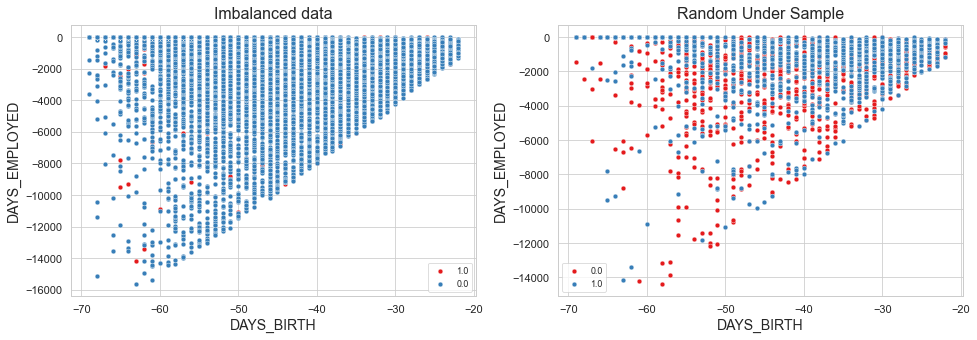

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2,
                        sharex=False, sharey=False,
                        figsize=(16,5))
fig.subplots_adjust(hspace=0.5)

for label, _ in counter1.items():
    row_ix = np.where(df_train[c_class].values == label)[0]
    sns.scatterplot(df_train[c_features].iloc[row_ix, 8],
                    df_train[c_features].iloc[row_ix, 9],
                    label=str(label),
                    ax=axes[0]
                    )
axes[0].set_title('Imbalanced data')

for label, _ in counter2.items():
    row_ix = np.where(y.values == label)[0]
    sns.scatterplot(X.iloc[row_ix, 8],
                    X.iloc[row_ix, 9],
                    label=str(label),
                    ax=axes[1]
                    )
axes[1].set_title('Random Under Sample')
print('\n\tArbitrary selection of 2 variables to see effect of under sampling ...')
plt.show()

### 3.2 Search for Classification method & Hyperparameters. WE VERIFY THAT WE GAIN 30% OF TIME OF TREATMENT WITH REDUCED SET  OF FEATURES

#### LinearSVC, XGBCClassifier, GradientBoostingClassifier best scores

In [6]:
models=[]
iname, itype, iparam = 0, 1, 2
models.append(['LinearSVC ', svm.LinearSVC(),
               { 
                'C': np.logspace(-4, 4, 9),
                'penalty' : ['l1', 'l2'],
                'loss': ['hinge', 'squared_hinge'],
                'dual': [False],
               }
              ])
models.append(['XGBClassifier', XGBClassifier(),
               {
                 'max_depth': [3,5],
                 'min_child_weight': [1, 5, 10],
                 'gamma': [0.5, 1, 1.5, 2, 5],
                 'subsample': [0.6, 0.8, 1.0],
                 'colsample_bytree': [0.6, 0.8, 1.0],
                 'verbosity': [0],
               }
              ])
models.append(['GradBoostC', ensemble.GradientBoostingClassifier(),
               {
                'n_estimators': [200],
                'max_depth': [3,5],
                'criterion': ['friedman_mse', 'squared_error'],
                'min_samples_split': [2, 3, 4],
                'min_weight_fraction_leaf': [0.0, 0.2, 0.4],
               }
              ])
for i, model in enumerate(models):
    mdl = GridSearchCV(model[itype], model[iparam], cv=5, scoring='roc_auc')
    datedeb = datetime.now()
    mdl.fit(X, y)
    duree = datetime.now() - datedeb
    print(f'{model[iname]} \tduree: {duree.seconds}s \tbest_score: {mdl.best_score_:4.3} \tbest_params: {mdl.best_params_}')


LinearSVC  	duree: 30s 	best_score: 0.688 	best_params: {'C': 0.1, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l1'}
XGBClassifier 	duree: 695s 	best_score: 0.705 	best_params: {'colsample_bytree': 0.8, 'gamma': 1, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0, 'verbosity': 0}
GradBoostC 	duree: 1109s 	best_score: 0.712 	best_params: {'criterion': 'friedman_mse', 'max_depth': 5, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.2, 'n_estimators': 200}


> For a 1174 '1 and 0 balanced classes' sample WITH ALL ORIGINAL FEATURES OR IMPORTANT FEATURES:  
  
>> LinearSVC  	duree: 112s 	best_score: 0.696 	best_params: {'C': 0.1, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l1'}  
>>  
>>  XGBClassifier 	duree: 1663s 	best_score: 0.723 	best_params: {'colsample_bytree': 1.0, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 1.0, 'verbosity': 0}  
>>  
>>  GradBoostC 	duree: 1631s 	best_score: 0.732 	best_params: {'criterion': 'friedman_mse', 'max_depth': 3, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.2, 'n_estimators': 200}

In [ ]:
del df_train, df_test
gc.collect()

### 3.3 Kfold Roc Curve and Feature Importances, WE VERIFY THAT WE HAVE THE SAME RESULTS AS WITH ALL ORIGINAL FEATURES

In [7]:
n_splits = 8
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

tot_valid_y = np.zeros(y.shape[0])
tot_valid_prob = np.zeros(y.shape[0])
tot_score = []
tot_feature_importances = []

for splt, (train_idx, valid_idx) in enumerate(skf.split(X, y)):

    train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
    valid_x, valid_y = X.iloc[valid_idx], y.iloc[valid_idx]
    
    # GradientBoostingClassifier
    gbc = ensemble.GradientBoostingClassifier(
        n_estimators=200,
        criterion='friedman_mse',
        max_depth=3,
        min_samples_split=2,
        min_weight_fraction_leaf=0.2,
    )
    gbc.fit(train_x, train_y)

    tot_valid_y[valid_idx] = valid_y
    
    valid_prob = gbc.predict_proba(valid_x)[:,1]
    tot_valid_prob[valid_idx] = valid_prob
    
    tot_score.append(metrics.roc_auc_score(valid_y.values, valid_prob))
    tot_feature_importances.append(gbc.feature_importances_)
    
tot_score = [round(1000*s)/1000 for s in tot_score] 
mean_score = sum(tot_score)/len(tot_score)
print(f'tot_score   = {[s for s in tot_score]}')
print(f'mean scores = {mean_score:5.3}')

tot_score   = [0.702, 0.712, 0.724, 0.701, 0.714, 0.653, 0.72, 0.707]
mean scores = 0.704


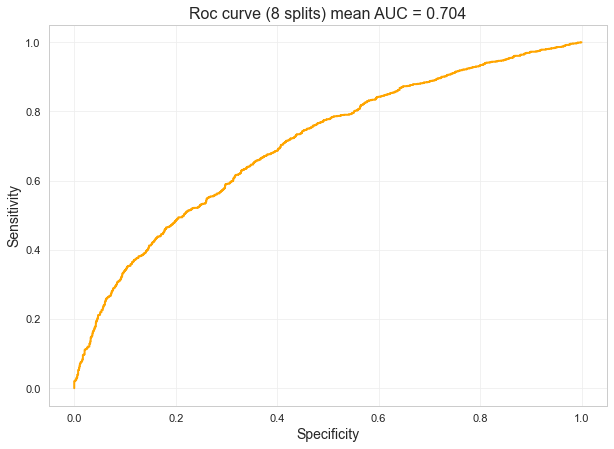

In [8]:

fig, axe = plt.subplots(figsize=(10,7))
[fpr, tpr, thr] = metrics.roc_curve(tot_valid_y,
                                    tot_valid_prob,
                                    pos_label=1)
axe.plot(fpr, tpr, color='orange', lw=2)
axe.set_title(f'Roc curve ({n_splits} splits) mean AUC = {mean_score:5.3}')
axe.set_xlabel('Specificity')
axe.set_ylabel('Sensitivity')
axe.grid(visible=True, color='#eeeeee')

plt.show()


##### Threshold 1: MINIMIZE THE RISK : we want to minimize the rate of False Positive, i.e minimize the pourcentage of loans attributed to wrong clients.

In [9]:
# Display thresholds for different False Positive Rate (FPR) tolerances
for max_fpr in np.arange(0.05, 0.65, 0.05):
    idx = np.max(np.where(fpr<max_fpr))
    str1 = f'False Pos Rate max {max_fpr:.2f} '
    str2 = f'Sensitivity: {tpr[idx]:.2f},  Specificity: {1-fpr[idx]:.2f} Threshold: {thr[idx]:.2f}'
    print(str1+str2)


False Pos Rate max 0.05 Sensitivity: 0.21,  Specificity: 0.95 Threshold: 0.75
False Pos Rate max 0.10 Sensitivity: 0.34,  Specificity: 0.90 Threshold: 0.68
False Pos Rate max 0.15 Sensitivity: 0.41,  Specificity: 0.85 Threshold: 0.63
False Pos Rate max 0.20 Sensitivity: 0.48,  Specificity: 0.80 Threshold: 0.59
False Pos Rate max 0.25 Sensitivity: 0.53,  Specificity: 0.75 Threshold: 0.56
False Pos Rate max 0.30 Sensitivity: 0.59,  Specificity: 0.70 Threshold: 0.53
False Pos Rate max 0.35 Sensitivity: 0.65,  Specificity: 0.65 Threshold: 0.50
False Pos Rate max 0.40 Sensitivity: 0.69,  Specificity: 0.60 Threshold: 0.47
False Pos Rate max 0.45 Sensitivity: 0.74,  Specificity: 0.55 Threshold: 0.44
False Pos Rate max 0.50 Sensitivity: 0.78,  Specificity: 0.50 Threshold: 0.41
False Pos Rate max 0.55 Sensitivity: 0.80,  Specificity: 0.45 Threshold: 0.39
False Pos Rate max 0.60 Sensitivity: 0.84,  Specificity: 0.40 Threshold: 0.36


##### Threshold 2: OPTIMIZE THE TURNOVER : we want to minimize the rate of False Negative, i.e minimize the pourcentage of loans refused to good clients.

In [10]:
# Display thresholds for different False Negative Rate (FNR) tolerances
# FNR = 1 - TPR
for min_tpr in np.arange(0.40, 1, 0.05):
    idx = np.min(np.where(tpr>min_tpr))
    str1 = f'False Neg Rate max {1-min_tpr:.2f} '
    str2 = f'Sensitivity: {tpr[idx]:.2f},  Specificity: {1-fpr[idx]:.2f} Threshold: {thr[idx]:.2f}'
    print(str1+str2)

False Neg Rate max 0.60 Sensitivity: 0.40,  Specificity: 0.86 Threshold: 0.64
False Neg Rate max 0.55 Sensitivity: 0.45,  Specificity: 0.82 Threshold: 0.61
False Neg Rate max 0.50 Sensitivity: 0.50,  Specificity: 0.78 Threshold: 0.58
False Neg Rate max 0.45 Sensitivity: 0.55,  Specificity: 0.74 Threshold: 0.55
False Neg Rate max 0.40 Sensitivity: 0.61,  Specificity: 0.69 Threshold: 0.52
False Neg Rate max 0.35 Sensitivity: 0.65,  Specificity: 0.65 Threshold: 0.50
False Neg Rate max 0.30 Sensitivity: 0.70,  Specificity: 0.59 Threshold: 0.47
False Neg Rate max 0.25 Sensitivity: 0.75,  Specificity: 0.54 Threshold: 0.44
False Neg Rate max 0.20 Sensitivity: 0.80,  Specificity: 0.45 Threshold: 0.39
False Neg Rate max 0.15 Sensitivity: 0.85,  Specificity: 0.38 Threshold: 0.35
False Neg Rate max 0.10 Sensitivity: 0.90,  Specificity: 0.28 Threshold: 0.30
False Neg Rate max 0.05 Sensitivity: 0.95,  Specificity: 0.15 Threshold: 0.23


#### Shape features and importances to find features with main role in classification

In [11]:
importance_mean = pd.DataFrame(tot_feature_importances).mean().to_list()
importance_std = pd.DataFrame(tot_feature_importances).std().to_list()
df_features = pd.DataFrame(data=np.array([[c for c in X.columns], importance_mean, importance_std]).T,
                           columns=['col name', 'mean def', 'std def'])
df_features['mean def'] = df_features['mean def'].astype('float64')
df_features['std def'] = df_features['std def'].astype('float64')
df_features.describe()

,mean def,std def
count,222.000000,222.000000
mean,0.004505,0.002339
std,0.008597,0.002388
min,0.000000,0.000000
25%,0.000432,0.000705
50%,0.001576,0.001746
75%,0.004276,0.003065
max,0.064194,0.017819


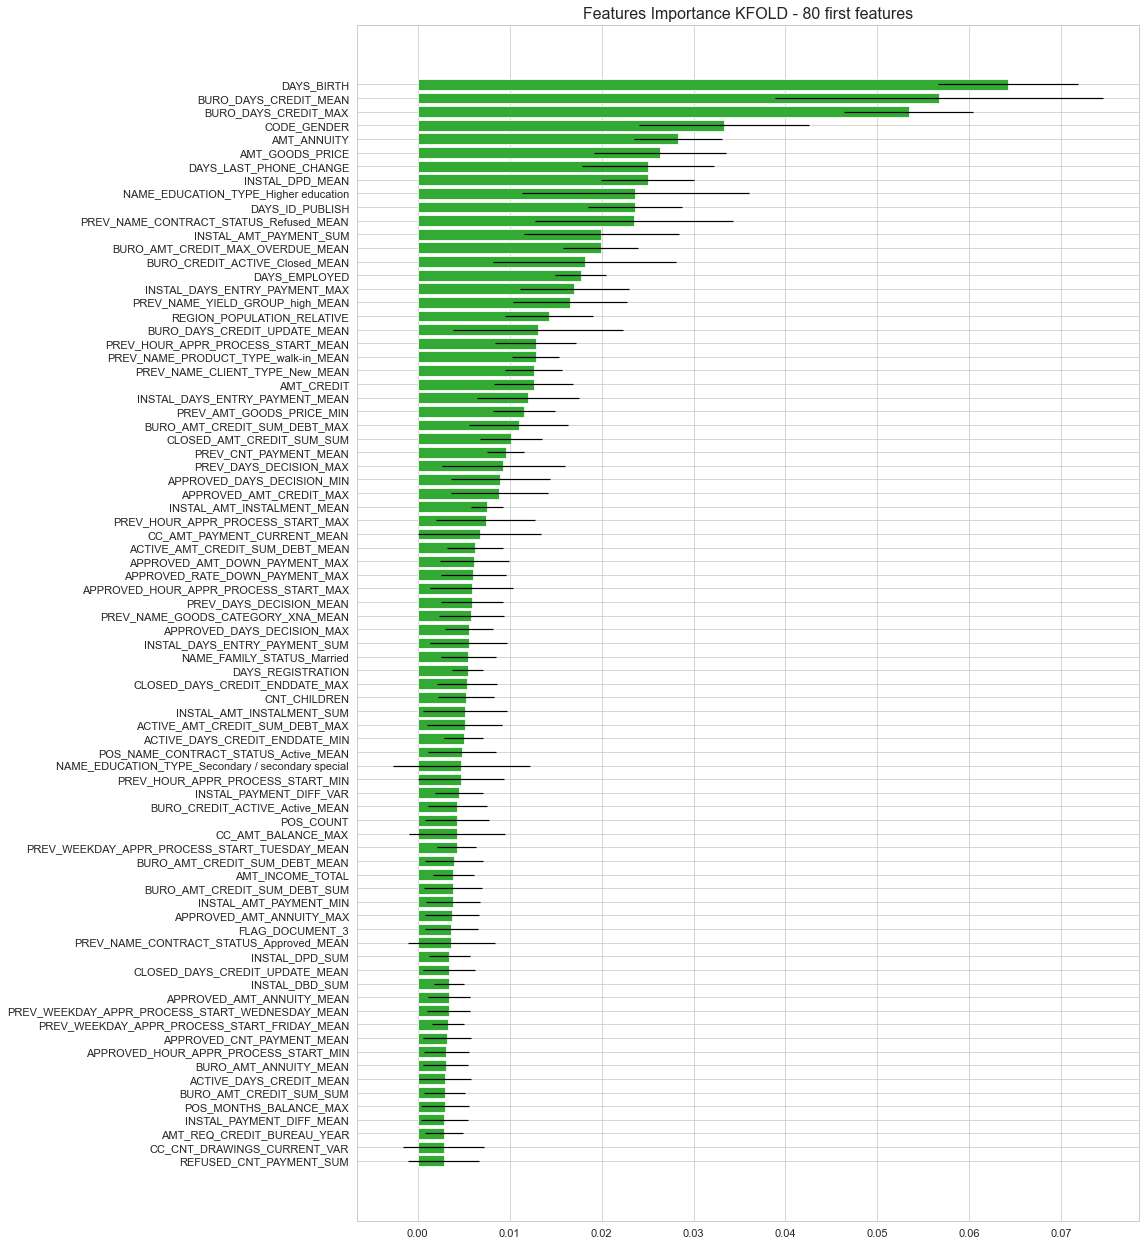

In [12]:

df_draw = df_features.sort_values('mean def')
df_draw = df_draw.iloc[-80:,:]
fig, axes = plt.subplots(figsize=(14,int(df_draw.shape[0]//3.5)))
axes.barh([x for x in range(df_draw.shape[0])],
           df_draw['mean def'].values,
           xerr = df_draw['std def'].values,
           color = '#33aa33',
           tick_label=df_draw['col name'].values)
axes.set_title(f'Features Importance KFOLD - {df_draw.shape[0]} first features')
axes.grid(visible=True)
plt.show()
